# North Korea missile tests and provocations

# Process Elon's Twitter timeline

#### Load Python tools

In [1]:
%load_ext lab_black

In [33]:
import pandas as pd
import geopandas as gpd
import altair as alt
import altair_grid as altgrid
import requests
from bs4 import BeautifulSoup
import re
import numpy as np

In [3]:
alt.themes.register("grid", altgrid.theme)
alt.themes.enable("grid")

ThemeRegistry.enable('grid')

In [4]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

In [5]:
today = pd.to_datetime("today").strftime("%Y-%m-%d")

---

In [6]:
my_headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OSX 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko)Chrome/71.0.3578.98 Safari/537.36",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
}

In [7]:
session = requests.Session()

In [8]:
url = "https://www.nti.org/analysis/articles/cns-north-korea-missile-test-database/"
response = session.get(url, headers=my_headers)

In [9]:
html_soup = BeautifulSoup(response.text, "html.parser")

In [10]:
report_url = html_soup.find("a", href=re.compile("uploads"))["href"]

In [11]:
!curl {report_url} --output data/raw/report.xlsx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  154k  100  154k    0     0   441k      0 --:--:-- --:--:-- --:--:--  447k


In [23]:
src = pd.read_excel("data/raw/report.xlsx", header=[1])

In [24]:
src.columns = (
    src.columns.str.lower()
    .str.replace(" ", "_", regex=False)
    .str.replace("/", "_", regex=False)
    .str.replace("_(utc)", "utc", regex=False)
)

In [25]:
src = src.sort_values("date", ascending=False)

In [26]:
src.replace("Unknown", np.nan, regex=False, inplace=True)

In [27]:
src["distance_travelled"] = (
    src["distance_travelled"]
    .str.replace(" km", "", regex=False)
    .str.replace(",", "", regex=False)
)
src["apogee"] = (
    src["apogee"].str.replace(" km", "", regex=False).str.replace(",", "", regex=False)
)

In [28]:
src["distance_miles"] = (src["distance_travelled"].astype(float) / 1.609).round()
src["apogee_miles"] = (src["apogee"].astype(float) / 1.609).round()

In [29]:
src.drop(
    [
        "distance_travelled",
        "apogee",
        "launch_agency_authority",
        "other_name",
        "f1",
        "confirmation_status",
    ],
    axis=1,
    inplace=True,
)

In [30]:
df = src.copy()

In [55]:
df[df]

,date,date_entered_updated,launch_timeutc,missile_name,missile_type,facility_name,facility_location,facility_latitude,facility_longitude,landing_location,test_outcome,additional_information,source(s),distance_miles,apogee_miles,geometry
172,2022-03-24,NaT,05:34:00,Hwasong-17,ICBM,Pyongyang International Airport,"Pyongyang, North Korea",39.200159,125.673256,Sea of Japan or East Sea,Success,"At 2:34 PM local time on March 24, 2022, North...",https://en.yna.co.kr/view/AEN20220324007454325...,677.0,3883.0,POINT (125.67326 39.20016)
171,2022-03-16,2022-03-16,00:30:00,NaN,NaN,Pyongyang International Airport,"Pyongyang, North Korea",39.200159,125.673256,NaN,Failure,North Korea conducted an attempted launch on M...,https://twitter.com/ELINTNews/status/150389460...,NaN,NaN,POINT (125.67326 39.20016)
170,2022-03-04,2022-03-24,23:48:00,NaN,MRBM,Pyongyang International Airport,"Pyongyang, North Korea",39.200159,125.673256,Sea of Japan or East Sea,Success,At 8:48 AM on March 5 (local time) North Korea...,https://en.yna.co.kr/view/AEN20220305000853325...,168.0,348.0,POINT (125.67326 39.20016)
169,2022-02-26,2022-03-24,22:52:00,NaN,MRBM,Pyongyang International Airport,"Pyongyang, North Korea",39.200159,125.673256,Sea of Japan or East Sea,Success,"On February 27 (local time 7:52 AM), North Kor...",https://twitter.com/nktpnd/status/149804298309...,186.0,385.0,POINT (125.67326 39.20016)
168,2022-01-29,2022-02-22,23:52:00,Hwasong-12,IRBM,Mupyong-ni Arms Plant,"Mup'yong-ni, Chagang province",40.611208,126.425743,Sea of Japan or East Sea,Success,North Korea finished its January missile tests...,https://en.yna.co.kr/view/AEN20220130000353325...,497.0,1243.0,POINT (126.42574 40.61121)


In [37]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.facility_longitude, df.facility_latitude)
)

In [38]:
gdf.plot()

In [56]:
launches_grouped = (
    gdf.groupby(
        [
            "facility_longitude",
            "facility_latitude",
            "facility_name",
            "facility_location",
        ]
    )
    .size()
    .reset_index(name="count")
    .rename(
        columns={"facility_longitude": "longitude", "facility_latitude": "latitude"}
    )
)

In [57]:
launches_grouped_geo = gpd.GeoDataFrame(
    launches_grouped,
    geometry=gpd.points_from_xy(launches_grouped.longitude, launches_grouped.latitude),
)

<AxesSubplot:>

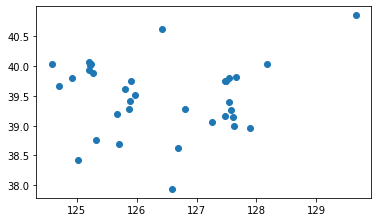

In [58]:
launches_grouped_geo.plot()

---

## Export

In [59]:
df.to_csv("data/processed/north_korea_launches.csv", index=False)

In [60]:
launches_grouped_geo.to_file(
    "data/processed/north_korea_launches_facility_counts.geojson", driver="GeoJSON"
)